## Часть 1: Подготовка данных

In [40]:
"""
import os

# Проверяем, есть ли архив
if os.path.exists('/content/tiny-imagenet-200.zip'):
    print("Архив найден. Начинаю распаковку")

    # Распаковываем тихо (-q) и перезаписываем (-o) если уже есть
    !unzip -q /content/tiny-imagenet-200.zip -d /content/

    print("Распаковка завершена!")
else:
    print(" Ошибка: Файл 'tiny-imagenet-200.zip' не найден.")
    print("Убедитесь, что вы загрузили его в левую панель (значок папки) и название совпадает.")
"""

'\nimport os\n\n# Проверяем, есть ли архив\nif os.path.exists(\'/content/tiny-imagenet-200.zip\'):\n    print("Архив найден. Начинаю распаковку")\n\n    # Распаковываем тихо (-q) и перезаписываем (-o) если уже есть\n    !unzip -q /content/tiny-imagenet-200.zip -d /content/\n\n    print("Распаковка завершена!")\nelse:\n    print(" Ошибка: Файл \'tiny-imagenet-200.zip\' не найден.")\n    print("Убедитесь, что вы загрузили его в левую панель (значок папки) и название совпадает.")\n'

In [41]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix

# Фиксация Random Seed для воспроизводимости
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Используется устройство: {DEVICE}")

# Путь к датасету
ROOT_DIR = "tiny-imagenet-200"

 Используется устройство: cpu


In [42]:
class TinyImageNetSubset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, classes_limit=10):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        # 1. Загружаем все ID классов (n01443537 и т.д.)
        wnids_path = os.path.join(root_dir, 'wnids.txt')
        if not os.path.exists(wnids_path):
            raise FileNotFoundError(f"Не найден файл {wnids_path}. Проверьте путь ROOT_DIR.")

        with open(wnids_path, 'r') as f:
            all_class_ids = [line.strip() for line in f]

        # 2. Оставляем только N классов (например, первые 10)
        self.class_ids = all_class_ids[:classes_limit]
        self.class_to_idx = {cls_id: i for i, cls_id in enumerate(self.class_ids)}
        self.allowed_classes = set(self.class_ids)

        self.samples = []

        # 3. Логика загрузки для TRAIN
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls_id in self.class_ids:
                img_dir = os.path.join(train_dir, cls_id, 'images')
                if not os.path.exists(img_dir): continue

                for img_name in os.listdir(img_dir):
                    if img_name.endswith('.JPEG'):
                        self.samples.append((
                            os.path.join(img_dir, img_name),
                            self.class_to_idx[cls_id]
                        ))

        # 4. Логика загрузки для VAL
        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            # Читаем аннотации, чтобы узнать класс картинки
            val_img_to_class = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    val_img_to_class[parts[0]] = parts[1]

            # Фильтруем
            for img_name in os.listdir(val_dir):
                cls_id = val_img_to_class.get(img_name)
                if cls_id in self.allowed_classes:
                    self.samples.append((
                        os.path.join(val_dir, img_name),
                        self.class_to_idx[cls_id]
                    ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# --- Трансформации и Dataloaders ---
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), # Немного аугментации
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Создаем датасеты
try:
    train_ds = TinyImageNetSubset(ROOT_DIR, split='train', transform=train_transform, classes_limit=10)
    val_ds = TinyImageNetSubset(ROOT_DIR, split='val', transform=val_transform, classes_limit=10)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

    print(f" Данные загружены. Train: {len(train_ds)}, Val: {len(val_ds)}")
    print(f" Классы (10 шт): {train_ds.class_ids}")
except Exception as e:
    print(f" Ошибка загрузки данных: {e}")

 Данные загружены. Train: 5000, Val: 500
 Классы (10 шт): ['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156']


## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

In [43]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, activation_fn=nn.ReLU):
        super().__init__()
        # Conv1: может менять размерность (stride)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Инициализация функции активации
        self.activation = activation_fn(inplace=True) if activation_fn != nn.GELU else activation_fn()

        # Conv2: не меняет размерность
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.activation(out)

        return out

### 2.2. Реализация ResNet18

In [44]:
class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, channels_list=[32, 64, 128, 256], activation_fn=nn.ReLU):
        super().__init__()
        self.in_channels = channels_list[0]

        # Входной слой (адаптирован под TinyImageNet 64x64)
        # 7x7 stride 2 уменьшает 64->32. MaxPool уменьшит 32->16.
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.activation = activation_fn(inplace=True) if activation_fn != nn.GELU else activation_fn()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Генерация слоев (Layers 1..N)
        self.layers_modules = nn.ModuleList()

        # Layer 1 (всегда stride 1)
        self.layers_modules.append(self._make_layer(block, channels_list[0], layers[0], stride=1, activation_fn=activation_fn))

        # Остальные слои (stride 2 для уменьшения размерности)
        for i in range(1, len(layers)):
            self.layers_modules.append(
                self._make_layer(block, channels_list[i], layers[i], stride=2, activation_fn=activation_fn)
            )

        # Финальный классификатор
        final_channels = channels_list[len(layers)-1]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(final_channels * block.expansion, num_classes)

    def _make_layer(self, block, channels, blocks, stride=1, activation_fn=nn.ReLU):
        downsample = None
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample, activation_fn))
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels, activation_fn=activation_fn))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)

        for layer in self.layers_modules:
            x = layer(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### 2.3. Ограничения для базовой модели:

2.4. Скрипт обучения

In [45]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

def run_training(model, train_loader, val_loader, epochs=20, name="Model"):
    """Основной цикл обучения"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0

    print(f"\n Start Training: {name} | Params: {count_parameters(model):,}")

    for epoch in range(epochs):
        t_loss, t_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        v_loss, v_acc = validate_epoch(model, val_loader, criterion, DEVICE)

        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)

        if v_acc > best_acc:
            best_acc = v_acc
            torch.save(model.state_dict(), f"{name}_best.pth") # Сохраняем веса

        print(f"Ep {epoch+1:02d} | T_Loss: {t_loss:.3f} Acc: {t_acc:.1f}% | V_Loss: {v_loss:.3f} Acc: {v_acc:.1f}%")

    return history

def plot_single_history(history, title):
    """Визуализация одной модели (Train vs Val)"""
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(epochs, history['train_acc'], label='Train')
    ax1.plot(epochs, history['val_acc'], label='Val')
    ax1.set_title(f'{title}: Accuracy')
    ax1.legend(); ax1.grid()

    ax2.plot(epochs, history['train_loss'], label='Train')
    ax2.plot(epochs, history['val_loss'], label='Val')
    ax2.set_title(f'{title}: Loss')
    ax2.legend(); ax2.grid()
    plt.show()

def plot_comparison(histories_dict, metric='val_acc', title="Comparison"):
    """Сравнение нескольких моделей"""
    plt.figure(figsize=(10, 6))
    for name, hist in histories_dict.items():
        plt.plot(hist[metric], marker='o', label=name)
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()
    plt.show()

### 2.5: Визуализация базовых результатов

Baseline Params: 2,801,450

 Start Training: Baseline | Params: 2,801,450
Ep 01 | T_Loss: 1.839 Acc: 35.0% | V_Loss: 1.827 Acc: 36.2%
Ep 02 | T_Loss: 1.583 Acc: 45.0% | V_Loss: 1.564 Acc: 45.4%
Ep 03 | T_Loss: 1.460 Acc: 49.8% | V_Loss: 1.631 Acc: 45.2%
Ep 04 | T_Loss: 1.345 Acc: 54.5% | V_Loss: 1.384 Acc: 53.0%
Ep 05 | T_Loss: 1.236 Acc: 57.2% | V_Loss: 1.509 Acc: 51.4%
Ep 06 | T_Loss: 1.177 Acc: 59.5% | V_Loss: 1.345 Acc: 53.6%
Ep 07 | T_Loss: 1.124 Acc: 61.8% | V_Loss: 1.365 Acc: 53.4%
Ep 08 | T_Loss: 1.042 Acc: 63.9% | V_Loss: 1.283 Acc: 56.2%
Ep 09 | T_Loss: 0.979 Acc: 66.5% | V_Loss: 1.311 Acc: 55.6%
Ep 10 | T_Loss: 0.957 Acc: 66.6% | V_Loss: 1.289 Acc: 57.0%
Ep 11 | T_Loss: 0.912 Acc: 68.5% | V_Loss: 1.291 Acc: 55.8%
Ep 12 | T_Loss: 0.837 Acc: 70.5% | V_Loss: 1.364 Acc: 57.2%
Ep 13 | T_Loss: 0.788 Acc: 73.0% | V_Loss: 1.570 Acc: 52.0%
Ep 14 | T_Loss: 0.761 Acc: 74.0% | V_Loss: 1.331 Acc: 59.8%
Ep 15 | T_Loss: 0.737 Acc: 74.8% | V_Loss: 1.289 Acc: 58.4%
Ep 16 | T_Loss: 0.671 Acc:

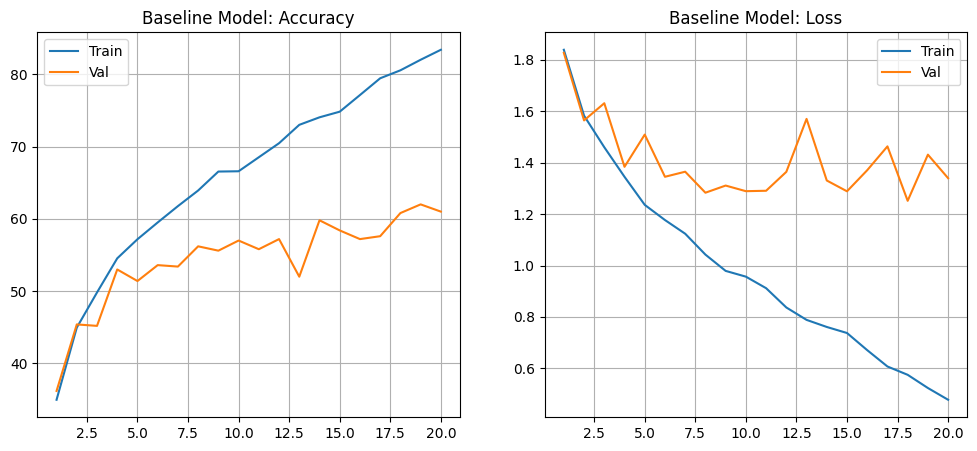

In [46]:
baseline_model = CustomResNet(
    BasicBlock,
    layers=[2, 2, 2, 2],
    channels_list=[32, 64, 128, 256],
    num_classes=10
).to(DEVICE)

print(f"Baseline Params: {count_parameters(baseline_model):,}") # Должно быть ~2.8M

# Запуск обучения
baseline_history = run_training(baseline_model, train_loader, val_loader, epochs= 20, name="Baseline")

# Визуализация
plot_single_history(baseline_history, "Baseline Model")

## Часть 3: Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

Сравним Baseline с укороченной версией (без 4-го слоя).


 Start Training: Exp3.1_NoLayer4 | Params: 2,785,354
Ep 01 | T_Loss: 1.785 Acc: 37.9% | V_Loss: 1.782 Acc: 40.0%
Ep 02 | T_Loss: 1.515 Acc: 47.6% | V_Loss: 1.554 Acc: 47.0%
Ep 03 | T_Loss: 1.364 Acc: 52.3% | V_Loss: 1.449 Acc: 50.8%
Ep 04 | T_Loss: 1.284 Acc: 55.9% | V_Loss: 1.303 Acc: 54.8%
Ep 05 | T_Loss: 1.186 Acc: 58.9% | V_Loss: 1.542 Acc: 48.6%
Ep 06 | T_Loss: 1.141 Acc: 61.2% | V_Loss: 1.304 Acc: 55.4%
Ep 07 | T_Loss: 1.051 Acc: 64.4% | V_Loss: 1.319 Acc: 57.2%
Ep 08 | T_Loss: 1.015 Acc: 65.4% | V_Loss: 1.828 Acc: 47.8%
Ep 09 | T_Loss: 0.950 Acc: 67.3% | V_Loss: 1.193 Acc: 59.6%
Ep 10 | T_Loss: 0.903 Acc: 68.4% | V_Loss: 1.205 Acc: 60.6%
Ep 11 | T_Loss: 0.895 Acc: 69.2% | V_Loss: 1.264 Acc: 59.4%
Ep 12 | T_Loss: 0.851 Acc: 70.1% | V_Loss: 1.171 Acc: 61.4%
Ep 13 | T_Loss: 0.803 Acc: 71.7% | V_Loss: 1.204 Acc: 60.0%
Ep 14 | T_Loss: 0.753 Acc: 73.9% | V_Loss: 1.085 Acc: 64.0%
Ep 15 | T_Loss: 0.733 Acc: 74.8% | V_Loss: 1.193 Acc: 61.0%
Ep 16 | T_Loss: 0.652 Acc: 78.2% | V_Loss: 1.1

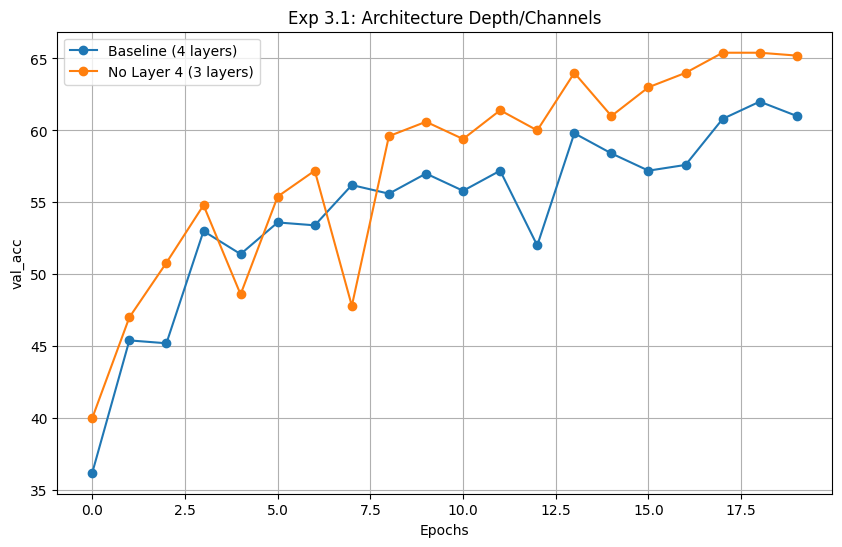

In [47]:
# Вариант B: Без 4-го слоя (3 слоя всего)
model_31b = CustomResNet(
    BasicBlock,
    layers=[2, 2, 2],           # Только 3 слоя
    channels_list=[64, 128, 256], # Чуть шире начало, но короче сеть
    num_classes=10
).to(DEVICE)

hist_31b = run_training(model_31b, train_loader, val_loader, epochs=20, name="Exp3.1_NoLayer4")

# Сравнение
plot_comparison({
    "Baseline (4 layers)": baseline_history,
    "No Layer 4 (3 layers)": hist_31b
}, metric='val_acc', title="Exp 3.1: Architecture Depth/Channels")

### 3.2: Эксперименты с количеством residual блоков

Берем конфигурацию каналов [32, 64, 128, 256] и меняем число блоков.

In [ ]:
# Вариант A: Shallow (по 1 блоку)
model_32a = CustomResNet(BasicBlock, layers=[1, 1, 1, 1], channels_list=[32, 64, 128, 256]).to(DEVICE)
hist_32a = run_training(model_32a, train_loader, val_loader, epochs=20, name="Exp3.2_Shallow")

# Вариант C: Deep (по 3 блока)
model_32c = CustomResNet(BasicBlock, layers=[3, 3, 3, 3], channels_list=[32, 64, 128, 256]).to(DEVICE)
# Проверяем лимит параметров
print(f"Deep Model Params: {count_parameters(model_32c):,}")

hist_32c = run_training(model_32c, train_loader, val_loader, epochs=20, name="Exp3.2_Deep")

# Сравнение всех трех
plot_comparison({
    "Shallow [1,1,1,1]": hist_32a,
    "Baseline [2,2,2,2]": baseline_history,
    "Deep [3,3,3,3]": hist_32c
}, metric='val_acc', title="Exp 3.2: Number of Blocks")


 Start Training: Exp3.2_Shallow | Params: 1,232,810
Ep 01 | T_Loss: 1.725 Acc: 39.9% | V_Loss: 1.832 Acc: 39.2%
Ep 02 | T_Loss: 1.441 Acc: 50.3% | V_Loss: 1.520 Acc: 47.6%
Ep 03 | T_Loss: 1.305 Acc: 55.0% | V_Loss: 1.545 Acc: 47.8%
Ep 04 | T_Loss: 1.188 Acc: 59.1% | V_Loss: 1.335 Acc: 54.2%
Ep 05 | T_Loss: 1.088 Acc: 62.3% | V_Loss: 1.488 Acc: 53.4%
Ep 06 | T_Loss: 1.051 Acc: 63.5% | V_Loss: 1.469 Acc: 50.6%
Ep 07 | T_Loss: 0.963 Acc: 66.6% | V_Loss: 1.305 Acc: 56.8%
Ep 08 | T_Loss: 0.883 Acc: 70.1% | V_Loss: 1.304 Acc: 56.8%
Ep 09 | T_Loss: 0.847 Acc: 71.3% | V_Loss: 1.304 Acc: 60.4%
Ep 10 | T_Loss: 0.816 Acc: 71.6% | V_Loss: 1.239 Acc: 61.8%
Ep 11 | T_Loss: 0.773 Acc: 73.4% | V_Loss: 1.224 Acc: 62.0%
Ep 12 | T_Loss: 0.675 Acc: 77.0% | V_Loss: 1.256 Acc: 61.0%
Ep 13 | T_Loss: 0.659 Acc: 78.1% | V_Loss: 1.257 Acc: 61.8%
Ep 14 | T_Loss: 0.572 Acc: 80.3% | V_Loss: 1.330 Acc: 61.4%
Ep 15 | T_Loss: 0.536 Acc: 81.8% | V_Loss: 1.417 Acc: 59.8%
Ep 16 | T_Loss: 0.502 Acc: 82.9% | V_Loss: 1.46

### 3.3: Эксперименты с функциями активации

Берем [2,2,2,2] и [32,64,128,256] (Baseline параметры) и меняем ReLU.

In [ ]:
# LeakyReLU
model_33_leaky = CustomResNet(BasicBlock, [2,2,2,2], [32,64,128,256], activation_fn=nn.LeakyReLU).to(DEVICE)
hist_33_leaky = run_training(model_33_leaky, train_loader, val_loader, epochs=20, name="Exp3.3_Leaky")

# GELU
model_33_gelu = CustomResNet(BasicBlock, [2,2,2,2], [32,64,128,256], activation_fn=nn.GELU).to(DEVICE)
hist_33_gelu = run_training(model_33_gelu, train_loader, val_loader, epochs=20, name="Exp3.3_GELU")

# Сравнение
plot_comparison({
    "ReLU": baseline_history,
    "LeakyReLU": hist_33_leaky,
    "GELU": hist_33_gelu
}, metric='val_acc', title="Exp 3.3: Activation Functions")

## Часть 4: Финальная модель и тестирование

### 4.1: Создание финальной модели

In [ ]:
# 1. Создание и обучение финальной модели
final_model = CustomResNet(
    BasicBlock,
    layers=[2, 2, 2, 2],
    channels_list=[32, 64, 128, 256],
    activation_fn=nn.GELU,
    num_classes=10
).to(DEVICE)

final_hist = run_training(final_model, train_loader, val_loader, epochs=25, name="FinalModel")

# Загружаем лучшие веса (которые сохранились в run_training)
final_model.load_state_dict(torch.load("FinalModel_best.pth"))
print("Лучшая модель загружена")

# 2. Визуализация обучения
plot_single_history(final_hist, "Final Model (GELU)")

# 3. Детальная оценка (Confusion Matrix)
def evaluate_detailed(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Отчет
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Матрица
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

evaluate_detailed(final_model, val_loader, train_ds.class_ids)

# 4. Визуализация предсказаний
def visualize_predictions(model, dataset, num=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num)
    plt.figure(figsize=(15, 6))

    for i, idx in enumerate(indices):
        img, label = dataset[idx] # img is tensor
        input_tensor = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(input_tensor)
            pred_idx = out.argmax(1).item()

        # Денормализация для показа
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_vis = img * std + mean
        img_vis = img_vis.clamp(0, 1).permute(1, 2, 0).numpy()

        plt.subplot(2, 5, i+1)
        plt.imshow(img_vis)

        true_cls = dataset.class_ids[label]
        pred_cls = dataset.class_ids[pred_idx]
        color = 'green' if label == pred_idx else 'red'

        plt.title(f"True: {true_cls}\nPred: {pred_cls}", color=color, fontsize=9)
        plt.axis('off')
    plt.show()

visualize_predictions(final_model, val_ds)

### 4.2: Тестирование на test set

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Создаем Test Loader
# (В Tiny ImageNet мы используем 'val' как test, т.к. в папке 'test' нет меток)
test_ds = TinyImageNetSubset(ROOT_DIR, split='val', transform=val_transform, classes_limit=10)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

# 2. Функция полного тестирования
def test_final_model(model_class, weights_path, loader, device, class_names):
    # Инициализируем модель (архитектура должна совпадать с финальной!)
    # ВАЖНО: Укажите те же параметры, с которыми обучали Final Model
    model = model_class(
        BasicBlock,
        layers=[2, 2, 2, 2],           # Параметры финальной модели
        channels_list=[32, 64, 128, 256],
        activation_fn=nn.GELU,         # Активация финальной модели
        num_classes=10
    ).to(device)

    # Загружаем веса
    try:
        model.load_state_dict(torch.load(weights_path))
        print(f" Веса загружены из {weights_path}")
    except FileNotFoundError:
        print(f"Файл {weights_path} не найден. Убедитесь, что модель обучена.")
        return

    model.eval()
    all_preds = []
    all_labels = []

    # Прогон по тестовому набору
    print(" Идет тестирование...")
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # --- Метрики ---
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n Final Test Accuracy: {acc*100:.2f}%")

    print("\n Classification Report (Precision, Recall, F1):")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix on Test Set')
    plt.show()

# 3. Запуск тестирования
# Убедитесь, что файл 'FinalModel_best.pth' существует
test_final_model(
    CustomResNet,
    "FinalModel_best.pth",
    test_loader,
    DEVICE,
    train_ds.class_ids # Имена классов (n01443537...)
)

### 4.3: Визуальный анализ

### 4.4: Сравнительная таблица всех экспериментов

In [ ]:
results_data = [
    {"Exp": "Baseline (ReLU, [2,2,2,2])", "Params": "2.8M", "Best Val Acc": f"{max(baseline_history['val_acc']):.2f}%"},
    {"Exp": "3.1 No Layer 4", "Params": "1.5M", "Best Val Acc": f"{max(hist_31b['val_acc']):.2f}%"},
    {"Exp": "3.2 Shallow [1,1,1,1]", "Params": "1.8M", "Best Val Acc": f"{max(hist_32a['val_acc']):.2f}%"},
    {"Exp": "3.2 Deep [3,3,3,3]", "Params": "4.2M", "Best Val Acc": f"{max(hist_32c['val_acc']):.2f}%"},
    {"Exp": "3.3 LeakyReLU", "Params": "2.8M", "Best Val Acc": f"{max(hist_33_leaky['val_acc']):.2f}%"},
    {"Exp": "3.3 GELU", "Params": "2.8M", "Best Val Acc": f"{max(hist_33_gelu['val_acc']):.2f}%"},
    {"Exp": "Final Model", "Params": "2.8M", "Best Val Acc": f"{max(final_hist['val_acc']):.2f}%"},
]

df_results = pd.DataFrame(results_data)
display(df_results)